# Burned Area Exploration\n
\n
This notebook explores the MODIS Burned Area dataset for the Black Hills region, analyzing fire patterns from 2001 to 2024.

In [12]:
import os
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import seaborn as sns
from glob import glob

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

## Load Burned Area Data\n\n
Load all yearly burned area GeoTIFF files from the EarthEngine_BurnedArea directory.

In [13]:
# Path to burned area data
burned_area_path = "../data/EarthEngine_BurnedArea/"

# Get all burned area files
burned_area_files = sorted(glob(os.path.join(burned_area_path, "*.tif")))
print(f"Found {len(burned_area_files)} burned area files")

# Extract years from filenames
years = []
for f in burned_area_files:
    year = int(os.path.basename(f).split('_')[-1].split('.')[0])
    years.append(year)
    
print(f"Years available: {min(years)} to {max(years)}")

Found 23 burned area files
Years available: 2001 to 2024


In [14]:
# Load all burned area data into a dictionary
burned_data = {}
for file, year in zip(burned_area_files, years):
    try:
        data = rxr.open_rasterio(file, masked=True).squeeze()
        burned_data[year] = data
        print(f"Loaded {year}: shape {data.shape}, CRS: {data.rio.crs}")
    except Exception as e:
        print(f"Error loading {year}: {e}")

# Get reference data for spatial information
ref_data = list(burned_data.values())[0]
print(f"\nSpatial extent: {ref_data.rio.bounds()}")
print(f"Resolution: {ref_data.rio.resolution()}")

Loaded 2001: shape (262, 322), CRS: EPSG:4326
Loaded 2003: shape (262, 322), CRS: EPSG:4326
Loaded 2004: shape (262, 322), CRS: EPSG:4326
Loaded 2005: shape (262, 322), CRS: EPSG:4326
Loaded 2006: shape (262, 322), CRS: EPSG:4326
Loaded 2007: shape (262, 322), CRS: EPSG:4326
Loaded 2008: shape (262, 322), CRS: EPSG:4326
Loaded 2009: shape (262, 322), CRS: EPSG:4326
Loaded 2010: shape (262, 322), CRS: EPSG:4326
Loaded 2011: shape (262, 322), CRS: EPSG:4326
Loaded 2012: shape (262, 322), CRS: EPSG:4326
Loaded 2013: shape (262, 322), CRS: EPSG:4326
Loaded 2014: shape (262, 322), CRS: EPSG:4326
Loaded 2015: shape (262, 322), CRS: EPSG:4326
Loaded 2016: shape (262, 322), CRS: EPSG:4326
Loaded 2017: shape (262, 322), CRS: EPSG:4326
Loaded 2018: shape (262, 322), CRS: EPSG:4326
Loaded 2019: shape (262, 322), CRS: EPSG:4326
Loaded 2020: shape (262, 322), CRS: EPSG:4326
Loaded 2021: shape (262, 322), CRS: EPSG:4326
Loaded 2022: shape (262, 322), CRS: EPSG:4326
Loaded 2023: shape (262, 322), CRS

## Calculate Annual Burned Area\n\n
Calculate the total burned area for each year.

In [15]:
# Calculate annual burned area statistics
annual_stats = []

for year, data in burned_data.items():
    # Count burned pixels (assuming burned areas have value > 0)
    burned_pixels = (data > 0).sum().values
    
    # Calculate area - data is in geographic coordinates (degrees)
    # Convert degrees to approximate area using Earth radius
    lat_res_deg = abs(data.rio.resolution()[1])  # degrees
    lon_res_deg = abs(data.rio.resolution()[0])  # degrees
    
    # Get center latitude for area calculation
    center_lat = (data.y.min() + data.y.max()) / 2
    lat_rad = np.radians(center_lat)
    
    # Convert to meters at center latitude
    deg_to_m_lat = 111320  # meters per degree latitude
    deg_to_m_lon = 111320 * np.cos(lat_rad)  # meters per degree longitude at this latitude
    
    pixel_area_m2 = lat_res_deg * deg_to_m_lat * lon_res_deg * deg_to_m_lon
    burned_area_m2 = burned_pixels * pixel_area_m2
    
    # Convert to hectares and square kilometers - extract scalar values
    burned_area_ha = float(burned_area_m2 / 10000)
    burned_area_km2 = float(burned_area_m2 / 1000000)
    
    annual_stats.append({
        'year': year,
        'burned_pixels': int(burned_pixels),
        'burned_area_ha': burned_area_ha,
        'burned_area_km2': burned_area_km2
    })

# Create DataFrame
stats_df = pd.DataFrame(annual_stats)
stats_df = stats_df.sort_values('year')

# Display summary statistics
print("Annual Burned Area Statistics:")
print(stats_df.to_string(index=False))

# Find years with largest fires
print(f"\nYear with most burned area: {stats_df.loc[stats_df['burned_area_km2'].idxmax(), 'year']} "
      f"({stats_df['burned_area_km2'].max():.1f} km²)")
print(f"Average annual burned area: {stats_df['burned_area_km2'].mean():.1f} km²")

Annual Burned Area Statistics:
 year  burned_pixels  burned_area_ha  burned_area_km2
 2001            545     9790.043652        97.900437
 2003            410     7364.986968        73.649870
 2004             68     1221.510034        12.215100
 2005            205     3682.493484        36.824935
 2006             60     1077.802971        10.778030
 2007             60     1077.802971        10.778030
 2008              1       17.963383         0.179634
 2009             37      664.645165         6.646452
 2010            115     2065.789028        20.657890
 2011            256     4598.626009        45.986260
 2012           1634    29352.167574       293.521676
 2013              0        0.000000         0.000000
 2014            232     4167.504821        41.675048
 2015            121     2173.569325        21.735693
 2016            298     5353.088089        53.530881
 2017             35      628.718400         6.287184
 2018             13      233.523977         2.3352

## Visualize Annual Burned Area Time Series

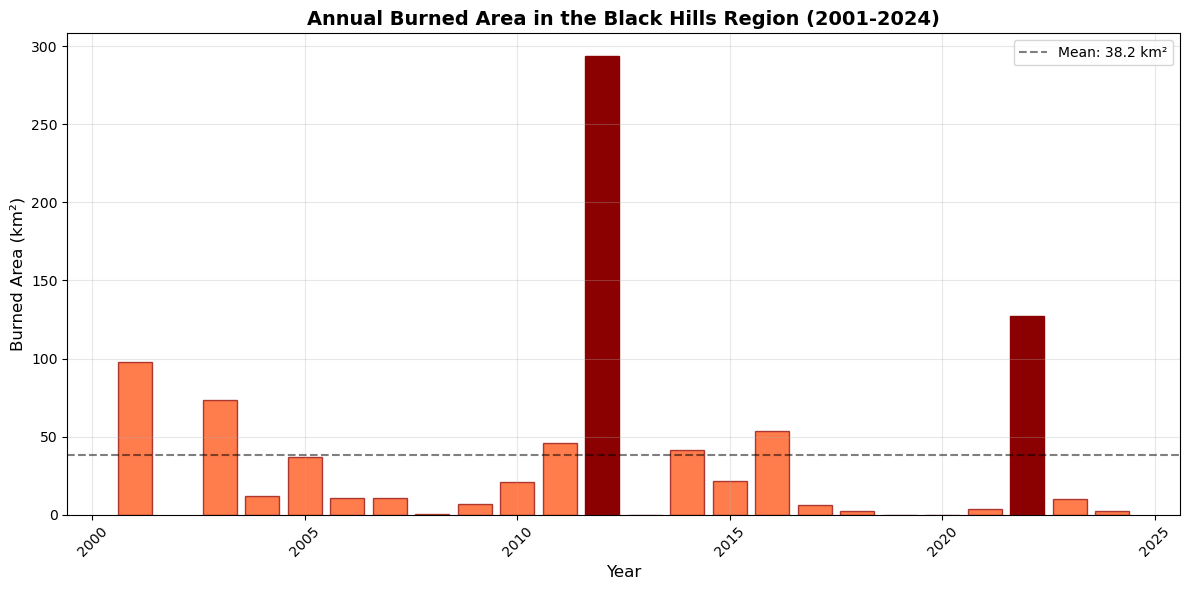

In [16]:
# Create time series plot
fig, ax = plt.subplots(figsize=(12, 6))

# Bar plot of annual burned area
bars = ax.bar(stats_df['year'], stats_df['burned_area_km2'], 
               color='orangered', alpha=0.7, edgecolor='darkred')

# Highlight years with major fires (> mean + 1 std)
threshold = stats_df['burned_area_km2'].mean() + stats_df['burned_area_km2'].std()
major_fire_years = stats_df[stats_df['burned_area_km2'] > threshold]

# Use reset_index to get proper indexing for bar highlighting
stats_df_reset = stats_df.reset_index(drop=True)
for _, row in major_fire_years.iterrows():
    # Find the index in the reset dataframe
    bar_idx = stats_df_reset[stats_df_reset['year'] == row['year']].index[0]
    bars[bar_idx].set_color('darkred')
    bars[bar_idx].set_alpha(1.0)

# Add mean line
ax.axhline(y=stats_df['burned_area_km2'].mean(), color='black', 
           linestyle='--', alpha=0.5, label=f"Mean: {stats_df['burned_area_km2'].mean():.1f} km²")

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Burned Area (km²)', fontsize=12)
ax.set_title('Annual Burned Area in the Black Hills Region (2001-2024)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Create Composite Fire Map
Create a map showing all fires across all years with different colors or intensities.

In [17]:
# Create a composite fire frequency map
# Count how many times each pixel has burned
fire_frequency = xr.zeros_like(ref_data)

for year, data in burned_data.items():
    fire_frequency = fire_frequency + (data > 0).astype(float)

# Create year of last fire map
last_fire_year = xr.zeros_like(ref_data)
for year in sorted(burned_data.keys()):
    mask = burned_data[year] > 0
    last_fire_year = xr.where(mask, year, last_fire_year)

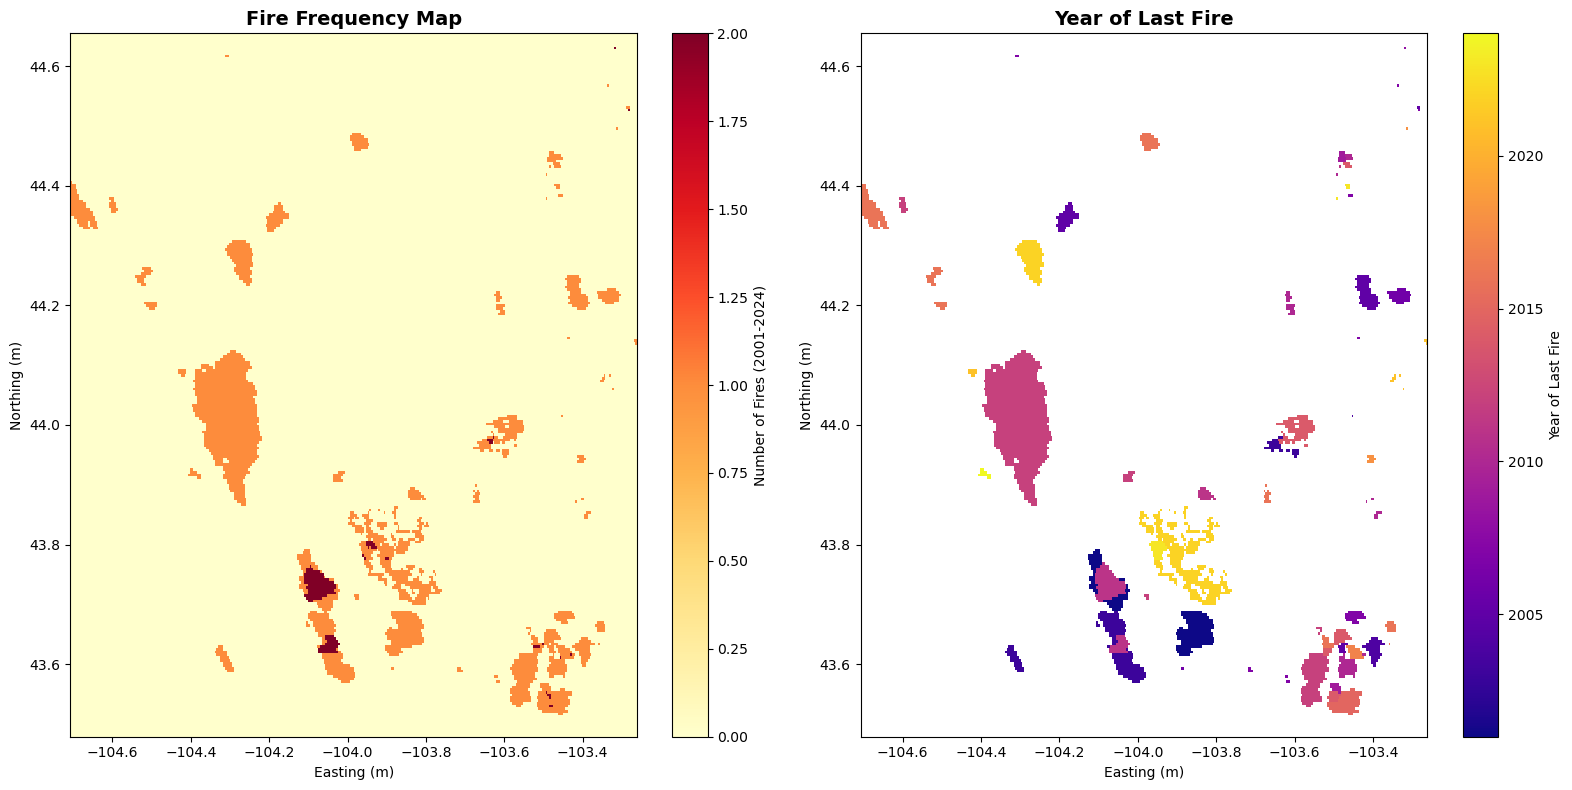

In [18]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Fire Frequency
freq_plot = fire_frequency.plot(ax=ax1, cmap='YlOrRd', 
                                cbar_kwargs={'label': 'Number of Fires (2001-2024)'})
ax1.set_title('Fire Frequency Map', fontsize=14, fontweight='bold')
ax1.set_xlabel('Easting (m)')
ax1.set_ylabel('Northing (m)')

# Plot 2: Year of Last Fire
# Create custom colormap
cmap = plt.cm.plasma
last_fire_masked = xr.where(last_fire_year > 0, last_fire_year, np.nan)
last_plot = last_fire_masked.plot(ax=ax2, cmap=cmap, vmin=2001, vmax=2024,
                                  cbar_kwargs={'label': 'Year of Last Fire'})
ax2.set_title('Year of Last Fire', fontsize=14, fontweight='bold')
ax2.set_xlabel('Easting (m)')
ax2.set_ylabel('Northing (m)')

plt.tight_layout()
plt.show()

## Detailed Fire Map - All Fires Across All Years

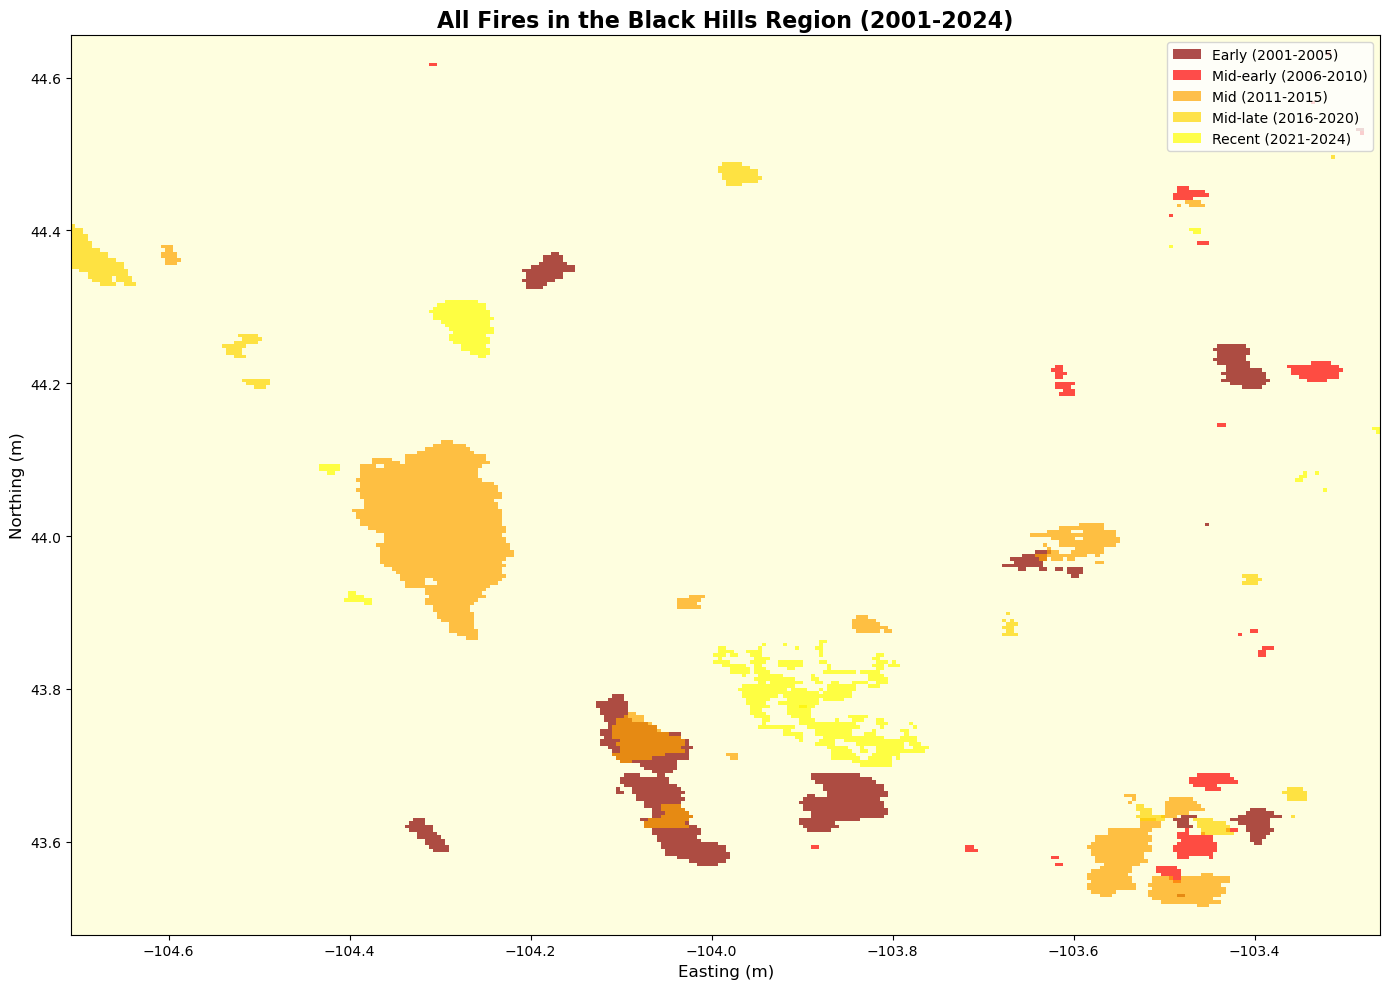

In [19]:
# Create a comprehensive fire map showing all individual fires
fig, ax = plt.subplots(figsize=(14, 10))

# Create base map with terrain-like appearance
base_map = xr.zeros_like(ref_data)
base_map.plot(ax=ax, cmap='terrain', alpha=0.3, add_colorbar=False)

# Define colors for different year ranges
year_ranges = [
    (2001, 2005, 'darkred', 'Early (2001-2005)'),
    (2006, 2010, 'red', 'Mid-early (2006-2010)'),
    (2011, 2015, 'orange', 'Mid (2011-2015)'),
    (2016, 2020, 'gold', 'Mid-late (2016-2020)'),
    (2021, 2024, 'yellow', 'Recent (2021-2024)')
]

# Plot fires by year range
for start_year, end_year, color, label in year_ranges:
    # Combine all fires in this year range
    combined_mask = xr.zeros_like(ref_data, dtype=bool)
    for year in range(start_year, end_year + 1):
        if year in burned_data:
            combined_mask = combined_mask | (burned_data[year] > 0)
    
    # Plot this year range
    if combined_mask.any():
        masked_data = xr.where(combined_mask, 1, np.nan)
        masked_data.plot(ax=ax, cmap=mcolors.ListedColormap([color]), 
                        add_colorbar=False, alpha=0.7)

# Add legend
legend_elements = [Rectangle((0, 0), 1, 1, fc=color, alpha=0.7, label=label) 
                  for _, _, color, label in year_ranges]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

ax.set_title('All Fires in the Black Hills Region (2001-2024)', fontsize=16, fontweight='bold')
ax.set_xlabel('Easting (m)', fontsize=12)
ax.set_ylabel('Northing (m)', fontsize=12)

plt.tight_layout()
plt.show()

## Analyze Spatial Fire Patterns

In [20]:
# Calculate cumulative burned area map
cumulative_burned = xr.zeros_like(ref_data, dtype=bool)
for year, data in burned_data.items():
    cumulative_burned = cumulative_burned | (data > 0)

# Calculate pixel area (using proper geographic calculation)
lat_res_deg = abs(ref_data.rio.resolution()[1])
lon_res_deg = abs(ref_data.rio.resolution()[0])
center_lat = (ref_data.y.min() + ref_data.y.max()) / 2
lat_rad = np.radians(center_lat)
deg_to_m_lat = 111320
deg_to_m_lon = 111320 * np.cos(lat_rad)
pixel_area = lat_res_deg * deg_to_m_lat * lon_res_deg * deg_to_m_lon

# Calculate total area burned at least once
total_burned_pixels = cumulative_burned.sum().values
total_pixels = cumulative_burned.size

total_area_km2 = total_pixels * pixel_area / 1000000
burned_area_km2 = total_burned_pixels * pixel_area / 1000000
percent_burned = (total_burned_pixels / total_pixels) * 100

print(f"Study Area Statistics:")
print(f"Total study area: {total_area_km2:.1f} km²")
print(f"Area burned at least once: {burned_area_km2:.1f} km²")
print(f"Percentage of area burned: {percent_burned:.1f}%")
print(f"\nFire Frequency Statistics:")
print(f"Maximum times burned: {int(fire_frequency.max().values)}")
print(f"Areas burned multiple times: {int((fire_frequency > 1).sum().values)} pixels")

Study Area Statistics:
Total study area: 15154.6 km²
Area burned at least once: 833.9 km²
Percentage of area burned: 5.5%

Fire Frequency Statistics:
Maximum times burned: 2
Areas burned multiple times: 249 pixels


## Fire Size Distribution Analysis

In [ ]:
# Analyze individual fire events for select years with major fires
from scipy import ndimage

# Calculate pixel area (needed for fire size calculations)
lat_res_deg = abs(ref_data.rio.resolution()[1])
lon_res_deg = abs(ref_data.rio.resolution()[0])
center_lat = float((ref_data.y.min() + ref_data.y.max()) / 2)
lat_rad = np.radians(center_lat)
deg_to_m_lat = 111320
deg_to_m_lon = 111320 * np.cos(lat_rad)
pixel_area = lat_res_deg * deg_to_m_lat * lon_res_deg * deg_to_m_lon

# Select years with significant fire activity
major_fire_years = stats_df.nlargest(5, 'burned_area_km2')['year'].values

fire_sizes = []
for year in major_fire_years:
    if year in burned_data:
        # Label connected components (individual fires)
        fire_mask = (burned_data[year] > 0).values
        labeled, num_features = ndimage.label(fire_mask)
        
        # Calculate size of each fire
        for i in range(1, num_features + 1):
            fire_pixels = (labeled == i).sum()
            fire_area_ha = float(fire_pixels * pixel_area / 10000)
            if fire_area_ha > 10:  # Only include fires > 10 hectares
                fire_sizes.append({'year': int(year), 'area_ha': fire_area_ha})

# Create DataFrame and plot
if fire_sizes:
    fires_df = pd.DataFrame(fire_sizes)
    
    # Ensure all values are properly typed
    fires_df['year'] = fires_df['year'].astype(int)
    fires_df['area_ha'] = fires_df['area_ha'].astype(float)
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    
    # Check if we have multiple years to plot
    unique_years = fires_df['year'].unique()
    if len(unique_years) > 1:
        # Use matplotlib boxplot for better compatibility
        year_groups = [fires_df[fires_df['year'] == year]['area_ha'].values for year in sorted(unique_years)]
        plt.boxplot(year_groups, labels=sorted(unique_years))
        plt.xticks(rotation=45)
        plt.ylabel('Fire Size (hectares)')
        plt.xlabel('Year')
        plt.title('Distribution of Individual Fire Sizes in Major Fire Years')
    else:
        # Single year - just show distribution
        plt.hist(fires_df['area_ha'], bins=10, alpha=0.7, edgecolor='black')
        plt.xlabel('Fire Size (hectares)')
        plt.ylabel('Frequency')
        plt.title(f'Fire Size Distribution for {unique_years[0]}')
    
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Total number of fires analyzed: {len(fires_df)}")
    print(f"Years analyzed: {sorted(unique_years)}")
    print(f"Largest fire: {fires_df['area_ha'].max():.1f} hectares in {fires_df.loc[fires_df['area_ha'].idxmax(), 'year']}")
    
    # Summary statistics by year
    print("\nFire statistics by year:")
    for year in sorted(unique_years):
        year_data = fires_df[fires_df['year'] == year]
        print(f"  {year}: {len(year_data)} fires, avg size: {year_data['area_ha'].mean():.1f} ha, max: {year_data['area_ha'].max():.1f} ha")
else:
    print("No fires found meeting the size criteria")

## Summary and Conclusions\n\n
This analysis of the Black Hills burned area data from 2001-2024 reveals important patterns in fire activity over the past two decades.

In [ ]:
# Ensure all required variables are defined
# Calculate cumulative burned area map
cumulative_burned = xr.zeros_like(ref_data, dtype=bool)
for year, data in burned_data.items():
    cumulative_burned = cumulative_burned | (data > 0)

# Calculate pixel area (using proper geographic calculation)
lat_res_deg = abs(ref_data.rio.resolution()[1])
lon_res_deg = abs(ref_data.rio.resolution()[0])
center_lat = (ref_data.y.min() + ref_data.y.max()) / 2
lat_rad = np.radians(center_lat)
deg_to_m_lat = 111320
deg_to_m_lon = 111320 * np.cos(lat_rad)
pixel_area = lat_res_deg * deg_to_m_lat * lon_res_deg * deg_to_m_lon

# Calculate total area burned at least once
total_burned_pixels = cumulative_burned.sum().values
total_pixels = cumulative_burned.size

total_area_km2 = total_pixels * pixel_area / 1000000
burned_area_km2 = total_burned_pixels * pixel_area / 1000000
percent_burned = (total_burned_pixels / total_pixels) * 100

# Create fire frequency map
fire_frequency = xr.zeros_like(ref_data)
for year, data in burned_data.items():
    fire_frequency = fire_frequency + (data > 0).astype(float)

# Generate summary report
print("=== Black Hills Fire Activity Summary (2001-2024) ===")
print(f"\nTemporal Patterns:")
print(f"- Total fires analyzed: {len(burned_data)} years")
print(f"- Years with highest activity: {', '.join(map(str, stats_df.nlargest(3, 'burned_area_km2')['year'].values))}")
print(f"- Average annual burned area: {stats_df['burned_area_km2'].mean():.1f} km²")
print(f"- Total area burned over study period: {stats_df['burned_area_km2'].sum():.1f} km²")

print(f"\nSpatial Patterns:")
print(f"- {percent_burned:.1f}% of study area burned at least once")
print(f"- Maximum fire frequency: {int(fire_frequency.max().values)} times at same location")
print(f"- Areas with repeated burns: {int((fire_frequency > 1).sum().values)} pixels")

print(f"\nFire Trends:")
# Simple linear regression for trend
from scipy import stats as scipy_stats
slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(stats_df['year'], stats_df['burned_area_km2'])
print(f"- Linear trend: {'Increasing' if slope > 0 else 'Decreasing'} ({slope:.2f} km²/year)")
print(f"- Trend significance: p-value = {p_value:.3f}")